In [2]:
import tarfile
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch
from PIL import Image
import wandb
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn import preprocessing
import torch.nn as nn
import scipy.io
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
wandb.login()
wandb.init(project="SML", entity="iiit-d")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tarang22081 (iiit-d). Use `wandb login --relogin` to force relogin


In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name[:3]: idx for idx, cls_name in enumerate(self.classes)}
        self.images = self._get_images()

    def _get_images(self):
        images = []
        # print(self.class_to_idx)
        for class_folder in self.classes:
            class_path = os.path.join(self.root_dir, class_folder)
            class_idx = self.class_to_idx[class_folder[:3]]
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_idx = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Example usage
root_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\train'
test_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\test'
train_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\new_train'
val_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\new_val'
trans = tt.Compose([
    tt.ToTensor(),tt.Resize((224,224)),tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))   
])

trans_aug = tt.Compose([
   tt.ToTensor(), tt.Resize((224,224)),
   tt.RandomGrayscale(), tt.RandomHorizontalFlip(),
   tt.RandomRotation(degrees=20), tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])


In [5]:
# train_dataset = CustomDataset(root_dir, transform=trans)
train_ds = CustomDataset(train_dir, transform=trans_aug)
val_ds = CustomDataset(val_dir, transform=trans)
test_ds = CustomDataset(test_dir, transform=trans)

In [6]:
batch = 128

In [7]:
train_dl = DataLoader(train_ds,batch, shuffle=True)
val_dl = DataLoader(val_ds,batch, shuffle=True)
test_dl = DataLoader(test_ds,batch, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


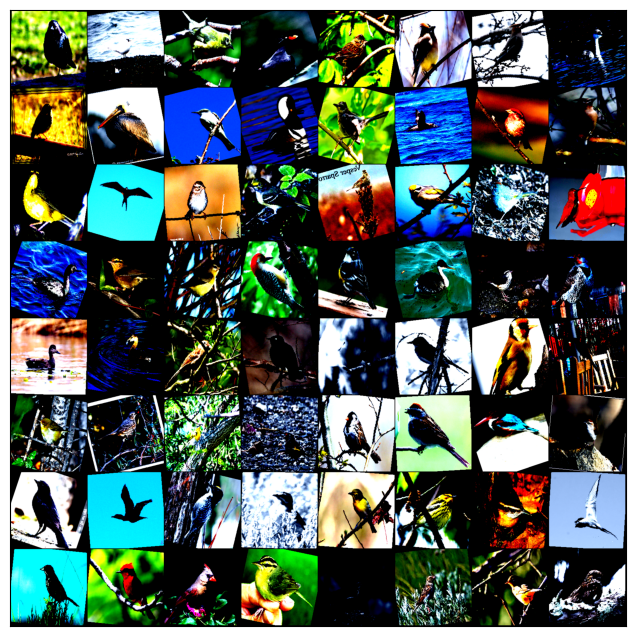

In [8]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))
    

def show_batch(dl, nmax=64):
    for images, label in dl:
        show_images(images, nmax)
        break
show_batch(train_dl,64)

In [9]:
#torchvision.models.alexnet(weights='DEFAULT')
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
print(model)

Using cache found in C:\Users\taran/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\taran\anaconda3\envs\NewGPU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\taran\anaconda3\envs\NewGPU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
model.classifier[6] = nn.Linear(4096, 200)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == (labels)).item() / len(preds))


class Model(nn.Module):
  def __init__(self ):
    super().__init__()
    self.network =model

  def forward(self, x):
    return self.network(x)
  
  def train_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred,label)
      return loss
  
  def valid_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred, label)  
      acc = accuracy(pred, label)
      return {'acc':acc , 'loss':loss.item()}

  def valid_metric_cals(self,output):
    loss = [i['loss'] for i in output]
    acc = [i['acc'] for i in output]
    valid_loss = np.mean(loss)
    valid_acc = np.mean(acc)
    return {'val_loss':valid_loss,'valid_acc':valid_acc}
  
  def epoch_end(self, epoch_no , result):
    wandb.log({ 'epoch' : epoch_no+1, 'training loss': result["train_loss"], 'validation loss': result["val_loss"], 'accuracy': result["valid_acc"]})
    print(f'epoch :{epoch_no+1}, training loss: {result["train_loss"]}, validation loss: {result["val_loss"]}, accuracy: {result["valid_acc"]}')

In [15]:
@torch.no_grad()
def evalu(model, val_dl):
  model.eval()
  temp = [ model.valid_step(j) for j in val_dl ]
  return model.valid_metric_cals(temp)

def fit(train_dl,val_dl,model,lr,optim,epochs,momentum):
  history = []
  optimizer =  optim(model.parameters(),lr=lr,momentum=0.9)
  count = 0
  for epoch in tqdm(range(epochs)):
    train_loss = []
    model.train()
    for batch in train_dl:
      optimizer.zero_grad()
      loss = model.train_step(batch)
      loss.backward()
      
      train_loss.append(loss.item())
      optimizer.step()
      # print(count)
      count+=1
    result = evalu(model,val_dl)
    result['train_loss'] = np.mean(train_loss)
    history.append(result)
    model.epoch_end(epoch,result)
  return history

    

In [16]:
model = Model()
model = to_device(model,'cuda')
lr = 0.001
momentum =.9
optimizer= torch.optim.SGD
epochs=10
wandb.config = {'lr':lr,'optimuzer':'SGD','epochs':epochs,'batch_size':batch}

In [17]:
# wandb.watch(model)
history=fit(train_dl,val_dl,model,lr,optimizer,epochs,momentum)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch :1, training loss: 5.232525110244751, validation loss: 4.842410469055176, accuracy: 0.05937499925494194
epoch :2, training loss: 4.207599457941558, validation loss: 3.458936595916748, accuracy: 0.2018229216337204
epoch :3, training loss: 3.049689506229601, validation loss: 2.860045909881592, accuracy: 0.3114583194255829
epoch :4, training loss: 2.4549976148103414, validation loss: 2.5739183902740477, accuracy: 0.35755208134651184
epoch :5, training loss: 2.0932089843248067, validation loss: 2.5191226482391356, accuracy: 0.3544270694255829
epoch :6, training loss: 1.760286149225737, validation loss: 2.358064556121826, accuracy: 0.3851562440395355
epoch :7, training loss: 1.5594089156702946, validation loss: 2.4235339403152465, accuracy: 0.4091145992279053
epoch :8, training loss: 1.411861937297018, validation loss: 2.5095169305801392, accuracy: 0.38723957538604736
epoch :9, training loss: 1.2284678001152842, validation loss: 2.4686256885528564, accuracy: 0.39791667461395264
epoch 

In [18]:
torch.save(model.state_dict(),"alexnet.pth")

In [19]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score

test_dl = DeviceDataLoader(test_dl,'cuda')
@torch.no_grad()
def test_accuracy_f1(test_dl):
  model.eval()
  acc=0
  f1=0
  list_label = []
  list_pred = []
  

  for num,(img,label) in enumerate(test_dl):
    outputs = model(img)
    batchs_report = []
    _, pred = torch.max(outputs, dim=1)
    predx,labelx = (pred.cpu().clone().tolist(),label.cpu().clone().tolist())
    
    list_label+=labelx
    list_pred+=predx
  f1 =f1_score(list_label,list_pred,average='macro')
  precision =precision_score(list_label,list_pred,average='macro')
  recall =recall_score(list_label,list_pred,average='macro')

  acc =accuracy_score(list_label,list_pred)
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                       y_true=list_label, preds=list_pred,
                     )})
  wandb.log({'f1_score':f1,'accuracy_score':acc,'precision Score':precision,'recall Score':recall})
  return f'f1 Score: {f1}', f'Accuracy: {acc}',f'precision Score: {precision}',f'recall Score: {recall}'
score_rate = test_accuracy_f1(test_dl)
print(score_rate)



('f1 Score: 0.41749657330467116', 'Accuracy: 0.4249223334483949', 'precision Score: 0.44871170122915155', 'recall Score: 0.42845415586076835')


In [20]:
wandb.finish()

accuracy,▁▄▆▇▇▇█▇██
accuracy_score,▁
epoch,▁▂▃▃▄▅▆▆▇█
f1_score,▁
precision Score,▁
recall Score,▁
training loss,█▆▄▃▃▂▂▁▁▁
validation loss,█▄▂▂▁▁▁▁▁▁
accuracy,0.41536
accuracy_score,0.42492
epoch,10
